In [20]:
import pathlib
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from Domain.Nutzenergieanalyse import NEAData

import Bevoelkerung
import Domain.General
import Energiebilanz
import General
import Nutzenergieanalyse
import Processor
import Utils


def create_general_data(g_laender_factory: Domain.General.GLaenderFactory):
    g_sektoren_factory = General.GSektorenDefaultFactory()
    g_bereiche_factory = General.GBereicheSimpleFactory()
    g_energietraeger_klassen_factory = General.GEnergietraegerKlassenSimpleFactory()
    g_energietraeger_factory = General.GEnergietraegerSimpleFactory()
    g_data_factory = General.GDataFactory(g_laender_factory, g_sektoren_factory, g_bereiche_factory,
                                          g_energietraeger_klassen_factory, g_energietraeger_factory)
    g_data = g_data_factory.create()
    return g_data

def create_nea_data(g_data: Domain.General.GData):
    nea_data_pickle_factory = Nutzenergieanalyse.NEADataPickleFactory(pathlib.Path('Data/Serialization'))
    nea_data_factory = Nutzenergieanalyse.NEADataETKlassenFactory(nea_data_pickle_factory)
    nea_data = nea_data_factory.create(g_data).data
    return {land.name: {sektor.name: {bereich.name: nea_data[land][sektor][bereich] for bereich in nea_data[land][sektor].keys()} for sektor in nea_data[land].keys()} for land in nea_data.keys()}

def create_eb_data(g_data: Domain.General.GData):
    eb_data_pickle_factory = Energiebilanz.EBDataPickleFactory(pathlib.Path('Data/Serialization'))
    eb_data_factory = Energiebilanz.EBDataETKlassenFactory(eb_data_pickle_factory)
    eb_data = eb_data_factory.create(g_data).data
    return {land.name: {sektor.name: eb_data[land][sektor] for sektor in eb_data[land].keys()} for land in eb_data.keys()}

def create_b_data(g_data: Domain.General.GData):
    b_data_factory = Bevoelkerung.BDataPickleFactory(pathlib.Path('Data/Serialization'), list(general_data.laender.values()))
    b_data = b_data_factory.create(list(general_data.laender.values())).data
    return {land.name: b_data[land] for land in b_data.keys()}
    
laender_factory = General.GBundeslaenderFactory()
general_data = create_general_data(laender_factory)

nea_data = create_nea_data(general_data)
eb_data = create_eb_data(general_data)
b_data = create_b_data(general_data)


In [3]:
def create_nea_data_sektor(land: str, sektor: str):
    return sum([nea_data[land][sektor][bereich.name] for bereich in general_data.bereiche.values()])

def create_nea_data_land(land: str):
    return sum([create_nea_data_sektor(land, sektor.name) for sektor in general_data.sektoren.values()])

def create_nea_data_bereich_oesterreich(sektor: str, bereich: str):
    return sum([nea_data[land.name][sektor][bereich] for land in general_data.laender.values()])

def create_nea_data_sektor_oesterreich(sektor: str):
    return sum([create_nea_data_sektor(land.name, sektor) for land in general_data.laender.values()])

def create_nea_data_oesterreich():
    return sum([create_nea_data_land(land.name) for land in general_data.laender.values()])

In [4]:
def clean_negative_values(data):
    df = data.copy()
    df[df < 0] = 0
    return df

def calc_relative(df: pd.DataFrame):
    return (df.transpose() / df.sum(axis=1)).transpose()


In [5]:
extrapolation = Utils.DFLinearExtrapolation()
extension = Utils.DFNanExtension()
extrapolation_extension = Utils.DFExtrapolationExtension(extrapolation)


In [6]:
def extend_nea_data(land: str, sektor: str, bereich: str):
    s = create_nea_data_sektor(land, sektor)
    b = nea_data[land][sektor][bereich]
    rel = (b / s).fillna(0)
    eb = eb_data[land][sektor]
    rel_ex = extrapolation_extension.run(rel, pd.PeriodIndex(pd.period_range(start='1988', end='2020', freq='A'), name=rel.index.name))
    return rel_ex * eb

def extend_all_nea_data():
    return {land: {sektor: {bereich: extend_nea_data(land, sektor, bereich) for bereich in nea_data[land][sektor].keys()} for sektor in nea_data[land].keys()} for land in nea_data.keys()}

nea_data_ex = extend_all_nea_data()


In [7]:
def create_data_bereich(land: str, sektor: str, bereich: str):
    nea = nea_data_ex[land][sektor][bereich]
    bevoelkerung = b_data[land]
    bevoelkerung = pd.Series(bevoelkerung, pd.period_range('1988', '2040', freq='A')).interpolate()
    nea_pp = (nea.transpose() / bevoelkerung['1988':'2020']).transpose().rolling(3).sum()['1990':]
    nea_pp_ex = extrapolation_extension.run(nea_pp, pd.PeriodIndex(pd.period_range(start=nea_pp.index[0], end='2040', freq='A'), name=nea_pp.index.name))
    return (clean_negative_values(nea_pp_ex.transpose()) * bevoelkerung['1990':]).transpose()

def create_data_sektor(land: str, sektor: str):
    return sum([create_data_bereich(land, sektor, bereich.name) for bereich in general_data.bereiche.values()])

def create_data_land(land: str):
    return sum([create_data_sektor(land, sektor.name) for sektor in general_data.sektoren.values()])

def create_data_oesterreich():
    return sum([create_data_land(land.name) for land in general_data.laender.values()])


In [90]:
def create_data_bereich_2(land: str, sektor: str, bereich: str):
    nea = nea_data_ex[land][sektor][bereich]
    bevoelkerung = b_data[land]
    bevoelkerung = pd.Series(bevoelkerung, pd.period_range('1988', '2040', freq='A')).interpolate()
    nea_pp = (nea.transpose() / bevoelkerung['1988':'2015']).transpose().rolling(3).sum()['1990':]
    nea_pp_ex = extrapolation_extension.run(nea_pp, pd.PeriodIndex(pd.period_range(start=nea_pp.index[0], end='2040', freq='A'), name=nea_pp.index.name))
    return (clean_negative_values(nea_pp_ex.transpose()) * bevoelkerung['1990':]).transpose()

def create_data_sektor_2(land: str, sektor: str):
    return sum([create_data_bereich_2(land, sektor, bereich.name) for bereich in general_data.bereiche.values()])

def create_data_land_2(land: str):
    return sum([create_data_sektor_2(land, sektor.name) for sektor in general_data.sektoren.values()])

def create_data_oesterreich_2():
    return sum([create_data_land_2(land.name) for land in general_data.laender.values()])

In [41]:
heizen_ph_wien = create_data_bereich('wien', 'Wohngebäude', 'Heizen')['1990':'2020']
heizen_ph_wien


,Fossile fest,Fossile flüssig,Fossile gasförmig,Brennbare Abfälle,Scheitholz,Biogene,Erneuerbare,Fernwärme,Elektrische Energie
1990,5254.073504,8127.778102,41163.674101,0.0,1502.682894,101.205622,40.871457,9914.345723,2626.933336
1991,4856.350214,8391.664777,41462.912014,0.0,1570.383172,102.964458,45.101642,11004.784426,2742.301508
1992,4440.687028,8539.419595,40570.286487,0.0,1592.170556,104.339885,50.189635,11724.158922,2828.131277
1993,3876.395324,8681.888334,42961.683928,0.0,1709.748510,105.734832,56.008783,12605.544194,2911.271783
1994,2991.085419,8082.917684,44699.461905,0.0,1765.627054,104.516229,63.807430,12724.540207,2890.654973
1995,2458.066746,8017.705479,45972.109593,0.0,2020.363094,104.632830,72.477083,13625.329178,2875.504696
1996,2207.065442,8385.972238,44132.145754,0.0,2391.332871,104.581101,82.162917,15055.245159,2804.163277
1997,1905.356934,8470.792017,43417.138654,0.0,2769.357455,107.464677,90.691216,16606.195792,2691.850289
1998,1613.319764,8307.479109,42325.065642,0.0,2931.007321,109.116031,99.336928,17345.601694,2581.156562
1999,1326.008741,7753.115202,45298.439094,0.0,2869.509611,103.537657,106.946315,17133.932372,2534.438309


In [11]:
data = nea_data_ex['wien']['Wohngebäude']['Heizen']['Fossile fest']

In [12]:
data

1988    2071.940148
1989    1665.880296
1990    1489.008889
1991    1660.491135
1992    1240.028201
1993     931.050432
1994     805.413024
1995     725.920416
1996     678.693132
1997     499.988081
1998     434.212272
1999     389.482008
2000     380.530959
2001     393.572834
2002     404.550498
2003     409.247238
2004     381.418424
2005     181.195145
2006     166.435841
2007      37.262199
2008      37.963667
2009      27.195096
2010      31.076815
2011     116.743915
2012     124.638636
2013      48.756073
2014      39.113066
2015       7.467088
2016       7.664656
2017       9.964228
2018       8.896231
2019       7.939638
2020       7.860208
Freq: A-DEC, Name: Fossile fest, dtype: float64

In [15]:
adfuller(data)

(-1.9173368793910763,
 0.32394976097350164,
 5,
 27,
 {'1%': -3.6996079738860943,
  '5%': -2.9764303469999494,
  '10%': -2.627601001371742},
 239.89113808430375)

This results in an ADF statistic of -1.91 and a p-value of 0.32. Here, the ADF statistic is not a large negative number and the p-value is greater than 0.05. Therefore, our time series is not stationary and we must apply transformations to make it stationary.

In [19]:
adfuller(data.diff()[1:])

(-5.285341957619576,
 5.871743261264857e-06,
 0,
 31,
 {'1%': -3.661428725118324,
  '5%': -2.960525341210433,
  '10%': -2.6193188033298647},
 232.4927072924417)

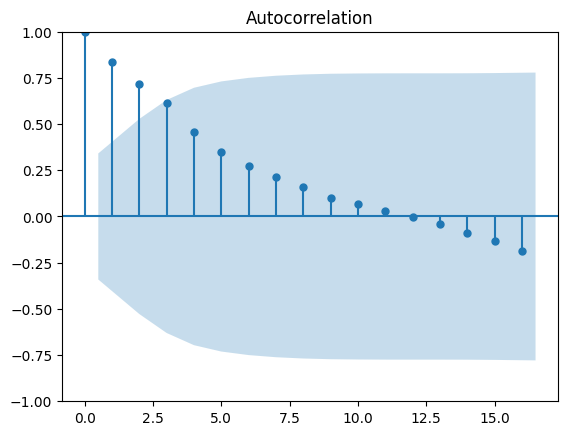

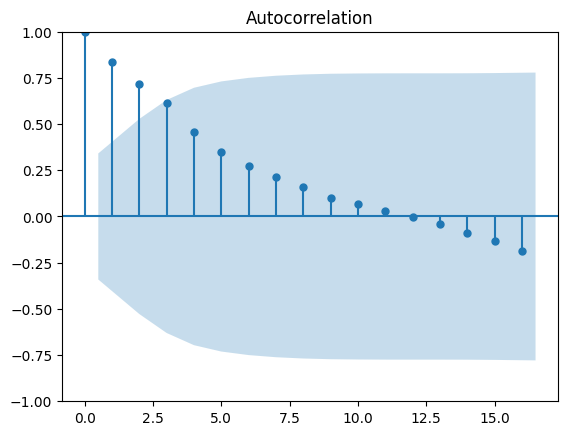

In [21]:
plot_acf(data)

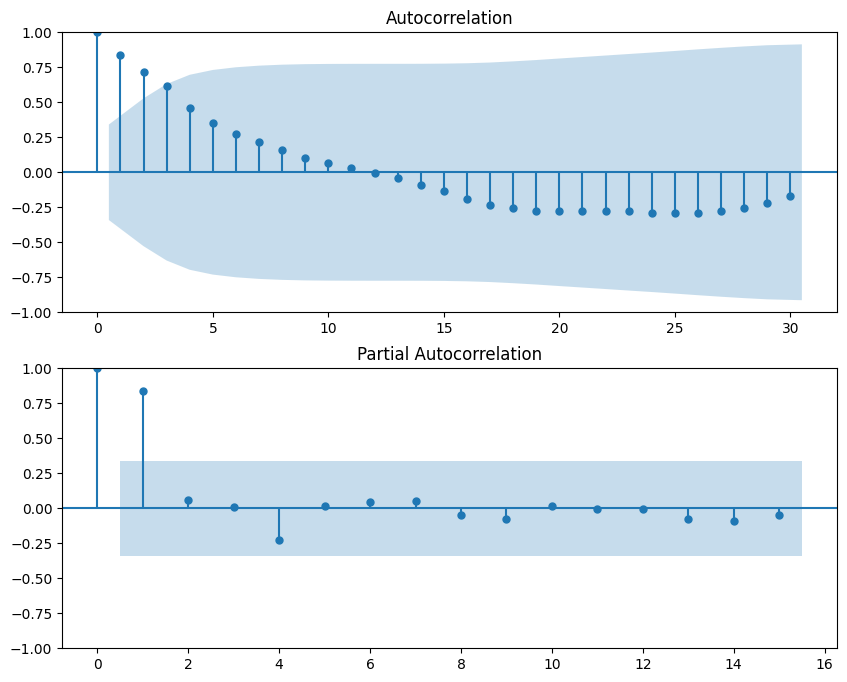

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(data, ax=ax1, lags=30)
plot_pacf(data, ax=ax2, lags=15)
plt.show()


<Axes: >

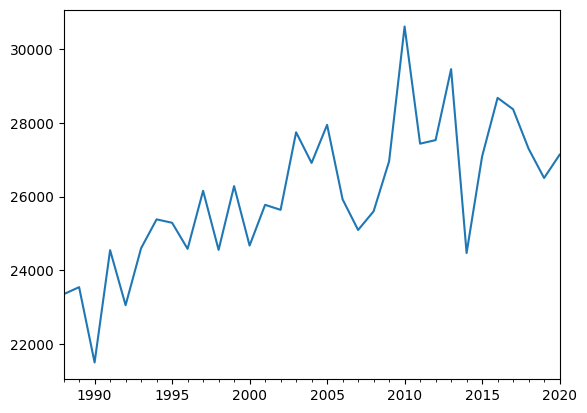

In [29]:
nea_data_ex['wien']['Wohngebäude']['Heizen'].sum(axis=1).plot()

In [87]:
import pmdarima as pm
from pmdarima import model_selection
import numpy as np
from matplotlib import pyplot as plt

# #############################################################################
# Load the data and split it into separate pieces
data = create_data_bereich('wien', 'Wohngebäude', 'Heizen').sum(axis=1)
train, test = model_selection.train_test_split(data['1990':'2020'], train_size=25)

# Fit a simple auto_arima model
arima = pm.auto_arima(train, seasonal=True)

# #############################################################################
# Plot actual test vs. forecasts:


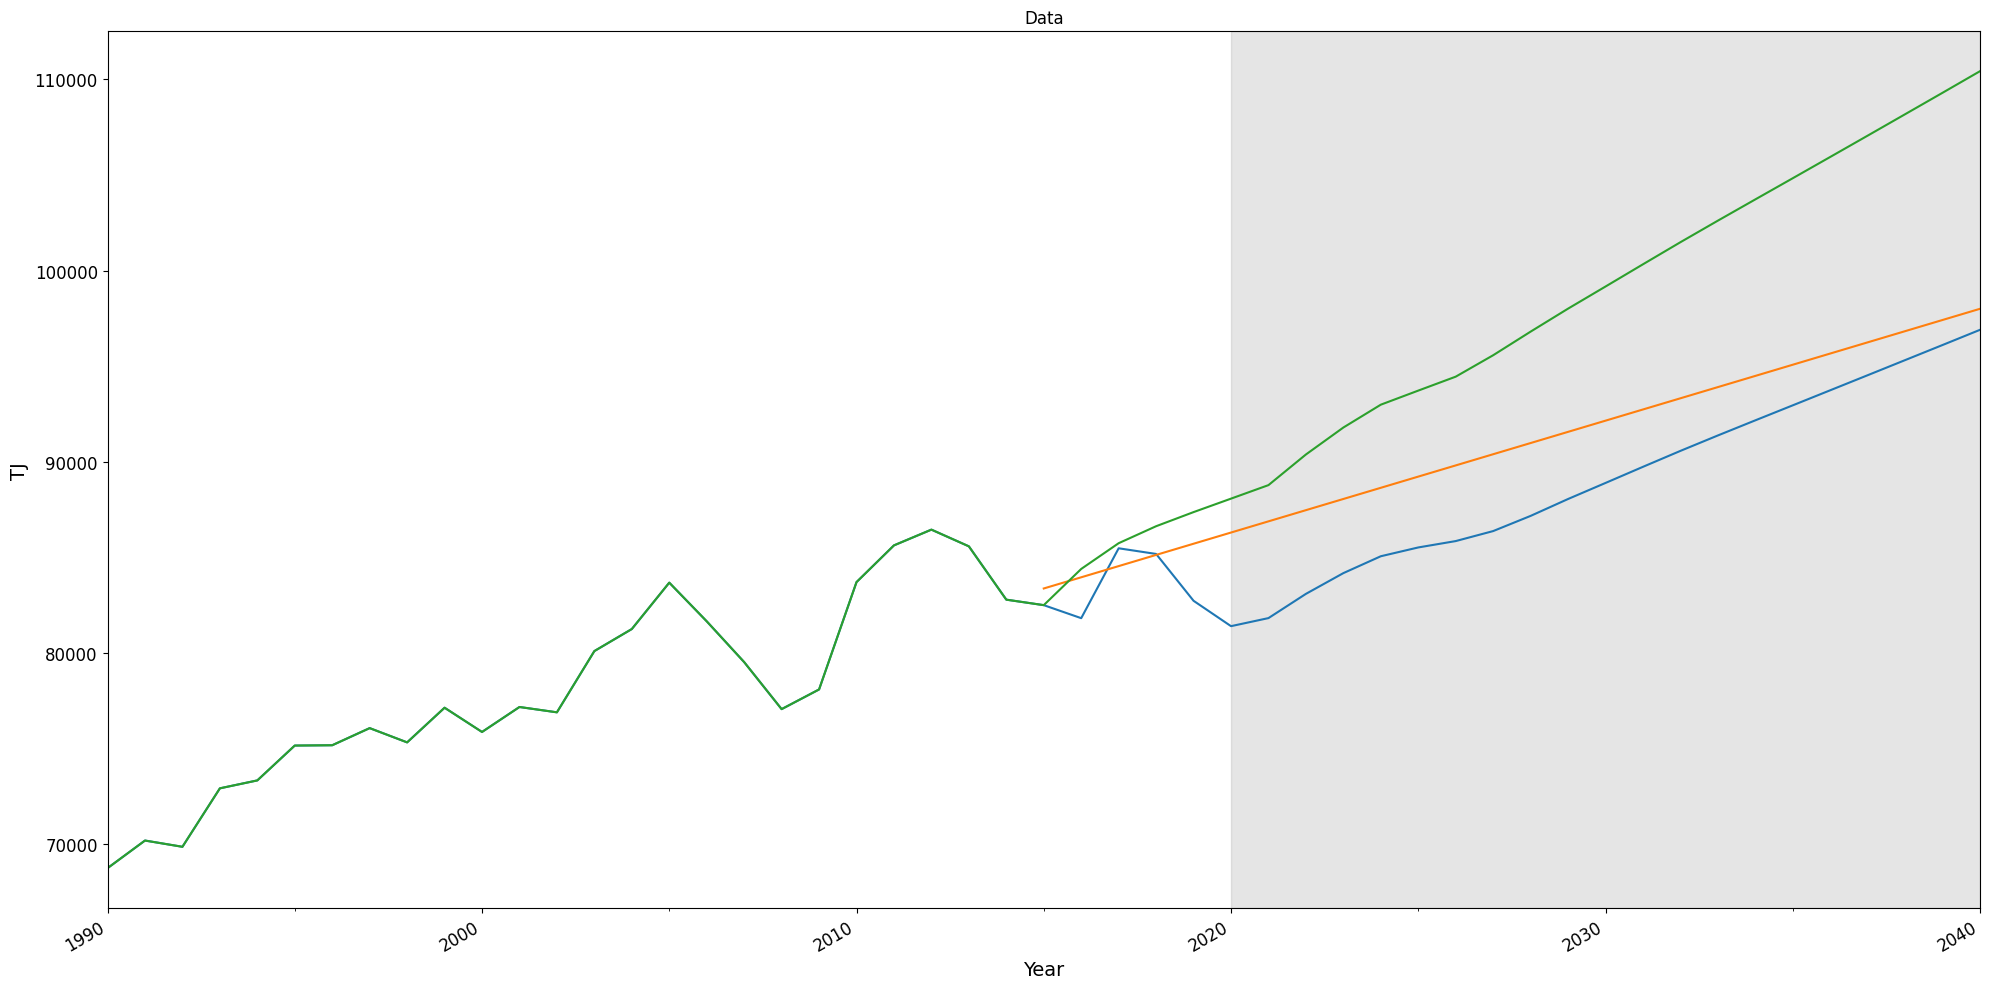

In [91]:
def since_epoch(period):
    return (period - pd.Period('1970-01-01', freq=period.freq)).n

matplotlib.rcParams["figure.figsize"] = (20,10)
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=False)

data.plot(ax=ax1)
ax1.set_title('Data')
ax1.set_xlabel('Year')
ax1.set_ylabel('TJ')


predict = arima.predict(n_periods=26)
predict.plot(ax=ax1)

data2 = create_data_bereich_2('wien', 'Wohngebäude', 'Heizen').sum(axis=1)
data2.plot(ax=ax1)
ax1.axvspan(since_epoch(data['2020':].index[0]), since_epoch(data.index[-1:][0]), color='#808080', alpha=0.2)

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

In [103]:
predict.name = "asd"
predict

2015    83364.883762
2016    83950.216523
2017    84535.549284
2018    85120.882045
2019    85706.214806
2020    86291.547567
2021    86876.880328
2022    87462.213089
2023    88047.545850
2024    88632.878611
2025    89218.211372
2026    89803.544133
2027    90388.876894
2028    90974.209655
2029    91559.542416
2030    92144.875176
2031    92730.207937
2032    93315.540698
2033    93900.873459
2034    94486.206220
2035    95071.538981
2036    95656.871742
2037    96242.204503
2038    96827.537264
2039    97412.870025
2040    97998.202786
Freq: A-DEC, Name: asd, dtype: float64

In [113]:
def extend_arima_series(series):
    train, test = model_selection.train_test_split(series['1990':'2020'], train_size=25)
    arima = pm.auto_arima(train, seasonal=True)
    predict = arima.predict(n_periods=26)
    return pd.concat([train, predict])

def extend_arima(df):
    return pd.DataFrame([extend_arima_series(df[col]) for col in df.columns]).transpose()
        

In [114]:
asd = extend_arima(create_data_bereich('wien', 'Wohngebäude', 'Heizen')['1990':'2020'])

C:\Users\johan\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


In [115]:
asd

,0,1,2,3,4,5,6,7,8
1990,5254.073504,8127.778102,41163.674101,0.0,1502.682894,101.205622,40.871457,9914.345723,2626.933336
1991,4856.350214,8391.664777,41462.912014,0.0,1570.383172,102.964458,45.101642,11004.784426,2742.301508
1992,4440.687028,8539.419595,40570.286487,0.0,1592.170556,104.339885,50.189635,11724.158922,2828.131277
1993,3876.395324,8681.888334,42961.683928,0.0,1709.748510,105.734832,56.008783,12605.544194,2911.271783
1994,2991.085419,8082.917684,44699.461905,0.0,1765.627054,104.516229,63.807430,12724.540207,2890.654973
1995,2458.066746,8017.705479,45972.109593,0.0,2020.363094,104.632830,72.477083,13625.329178,2875.504696
1996,2207.065442,8385.972238,44132.145754,0.0,2391.332871,104.581101,82.162917,15055.245159,2804.163277
1997,1905.356934,8470.792017,43417.138654,0.0,2769.357455,107.464677,90.691216,16606.195792,2691.850289
1998,1613.319764,8307.479109,42325.065642,0.0,2931.007321,109.116031,99.336928,17345.601694,2581.156562
1999,1326.008741,7753.115202,45298.439094,0.0,2869.509611,103.537657,106.946315,17133.932372,2534.438309


<Axes: >

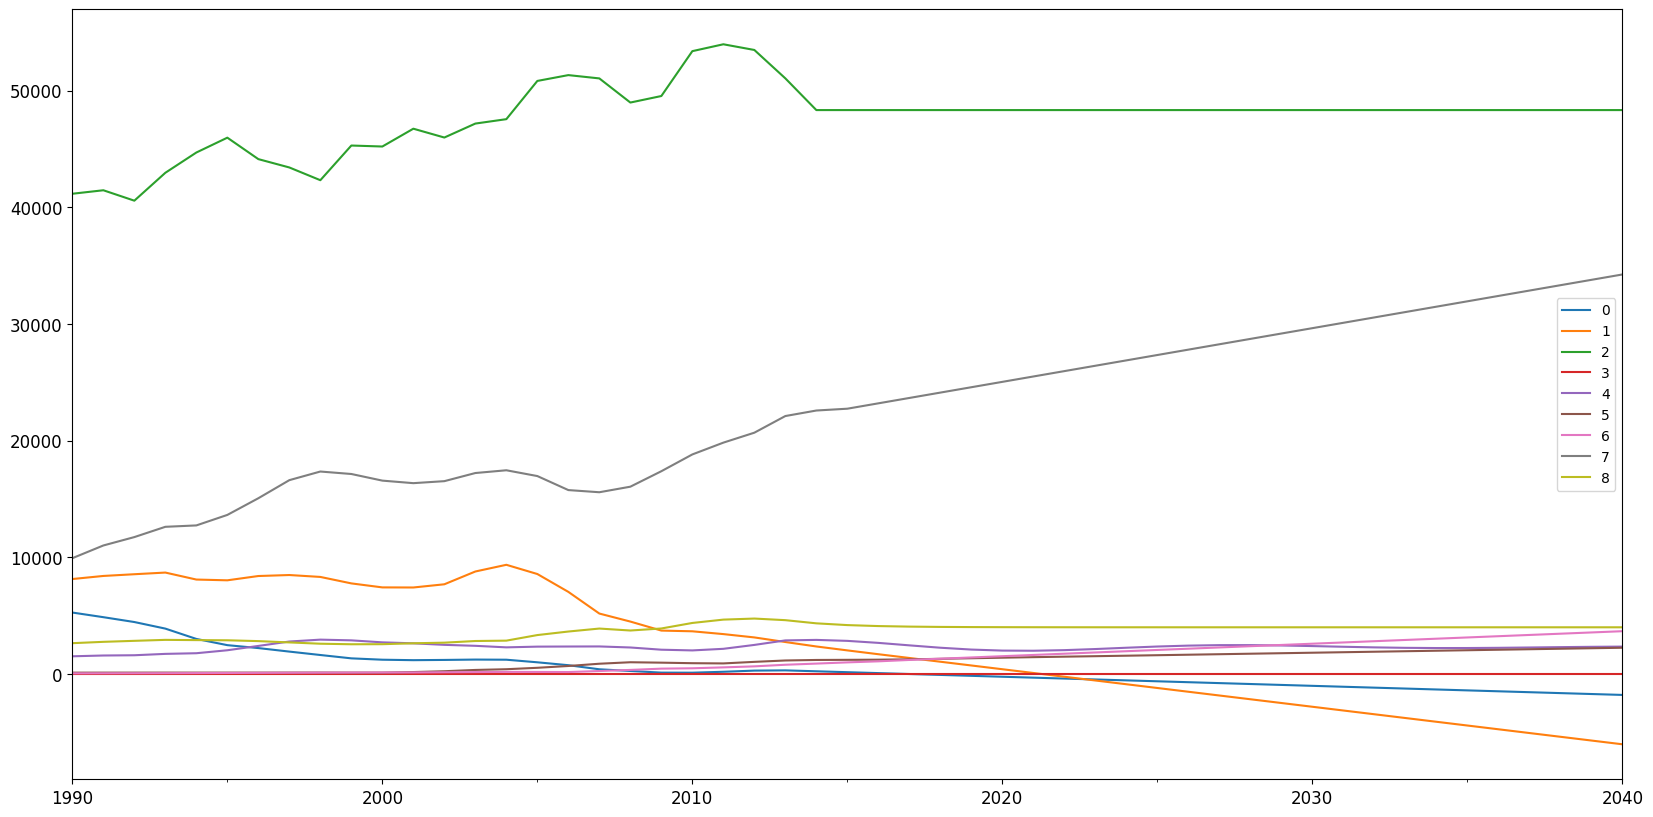

In [116]:
asd.plot()

<Axes: >

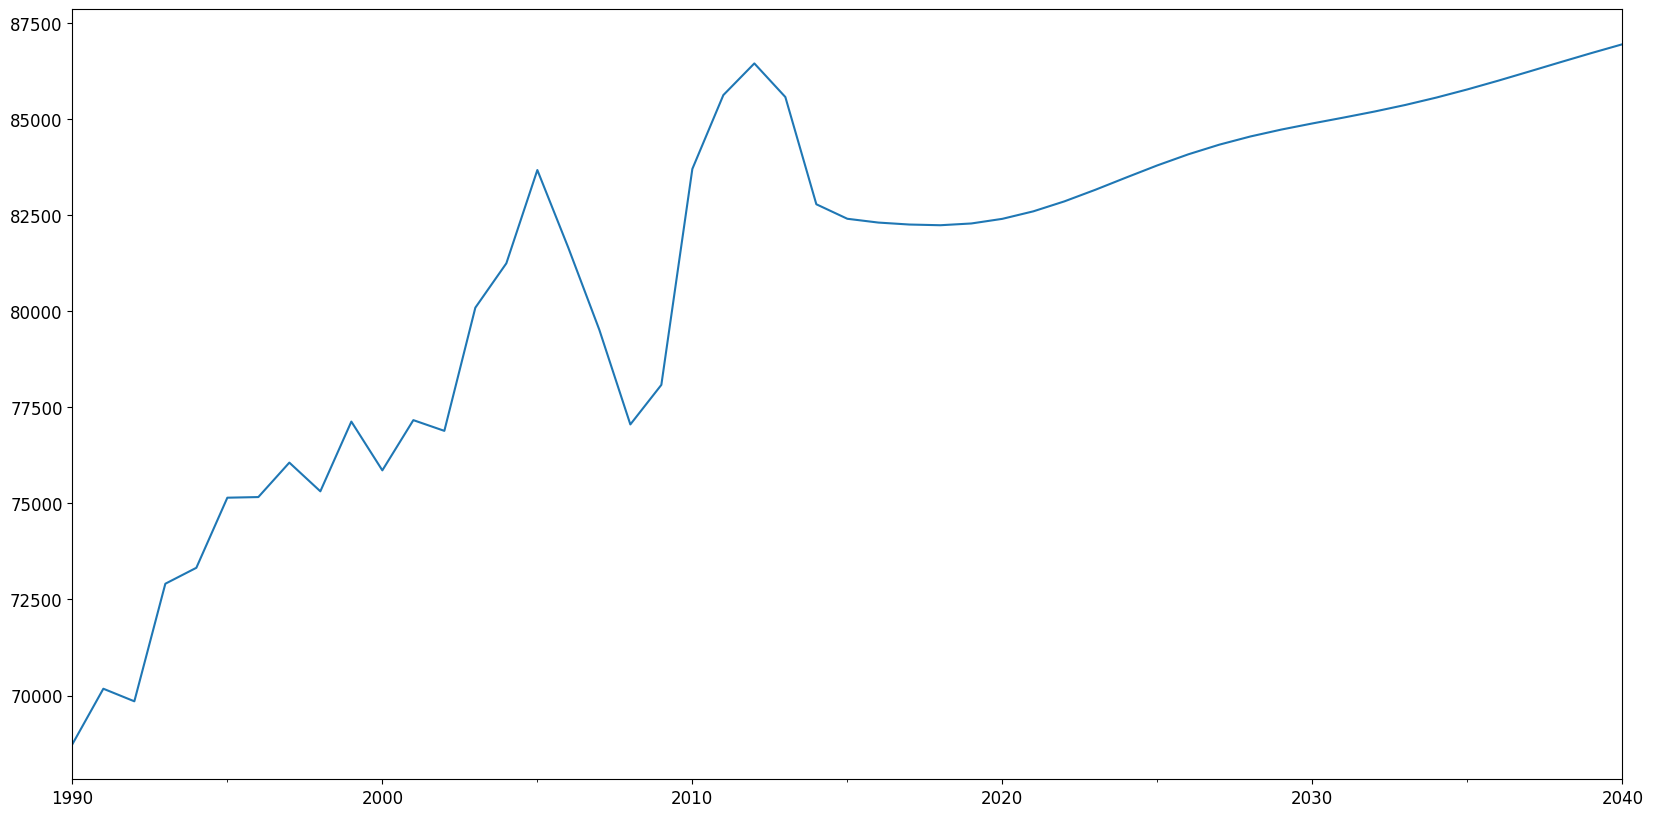

In [117]:
asd.sum(axis=1).plot()


<Axes: >

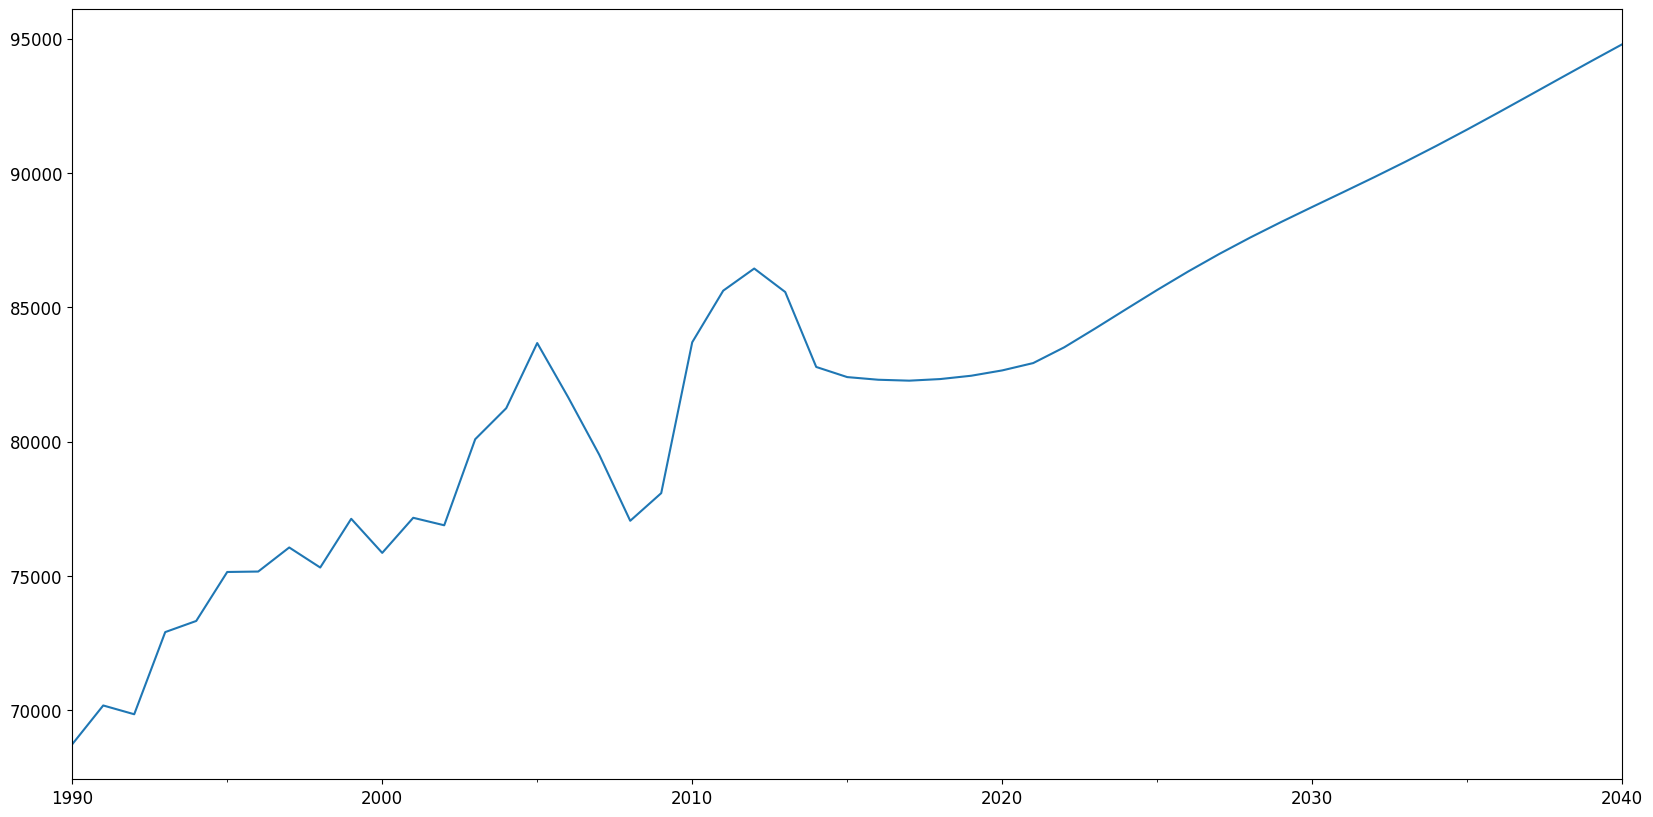

In [118]:
def clean_negative_values(data):
    df = data.copy()
    df[df < 0] = 0
    return df

clean_asd = clean_negative_values(asd)
clean_asd.sum(axis=1).plot()
